In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split as tts

In [6]:
batch_size=64
num_classes=10

In [7]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 11s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [8]:
x_train=x_train/255
x_test=x_test/255

In [9]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [10]:
import keras
from keras.models import Model
from keras.layers import Conv2D,Dense,Activation,AveragePooling2D,MaxPooling2D, Flatten, Dropout, BatchNormalization, Input, Add
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler

In [11]:
def resnet_block(input_layer,num_filters):
    merge_layer = input_layer
    
    if input_layer.shape[-1] != num_filters:
        
        merge_layer = Conv2D(filters= num_filters,kernel_size=(1,1),padding='same',activation='relu')(input_layer)
        merge_layer = BatchNormalization()(merge_layer)
        
    conv1_layer = Conv2D(filters=num_filters,kernel_size=(3,3),padding='same',activation='relu')(input_layer)
    conv1_layer = BatchNormalization()(conv1_layer)
        
    conv2_layer = Conv2D(filters=num_filters,kernel_size=(3,3),padding='same',activation='linear')(conv1_layer)
    
    output_layer = Add()([conv1_layer,conv2_layer])
    
    output_layer = Activation('relu')(output_layer)
    output_layer = BatchNormalization()(output_layer)
    
    return output_layer


In [12]:
def resnet_cifar10():
    
    input_=Input(shape=(32,32,3))
    
    num_filters=32
    num_layers=[1,2,2,1]
    
    layer=Conv2D(filters=num_filters,kernel_size=(3,3),padding='same',activation='relu')(input_)
    layer=BatchNormalization()(layer)
    layer=MaxPooling2D(2)(layer)
    
    for i in range(len(num_layers)):
        num_layers_i=num_layers[i]
        num_filters*=2
        for num in range(num_layers_i):
            layer = resnet_block(layer,num_filters)
        
    layer = AveragePooling2D(4)(layer)
    
    layer = Flatten()(layer)
    layer = Dense(units=1024,activation='relu')(layer)
    output = Dense(units=10, activation='softmax')(layer)
    
    model = Model(inputs=input_,outputs=output)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [13]:
model = resnet_cifar10()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
x_train,x_val,y_train,y_val = tts(x_train,y_train,test_size=0.08,random_state=6)

In [15]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_accuracy",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)

In [16]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_decay=LearningRateScheduler(scheduler)

In [17]:
callback_lists=[earlystopping,lr_decay]

In [18]:
history=model.fit(x_train,y_train , epochs=20, batch_size=batch_size, validation_data=(x_val,y_val),callbacks=[callback_lists],verbose =1,shuffle=True)

Epoch 1/20
719/719 [==============================] - 246s 332ms/step - loss: 2.1610 - accuracy: 0.3689 - val_loss: 1.6633 - val_accuracy: 0.4353
Epoch 2/20
719/719 [==============================] - 235s 328ms/step - loss: 1.1131 - accuracy: 0.6084 - val_loss: 2.0350 - val_accuracy: 0.4590
Epoch 3/20
719/719 [==============================] - 235s 327ms/step - loss: 0.9099 - accuracy: 0.6756 - val_loss: 1.2265 - val_accuracy: 0.6110
Epoch 4/20
719/719 [==============================] - 235s 327ms/step - loss: 0.7746 - accuracy: 0.7286 - val_loss: 0.9849 - val_accuracy: 0.6715
Epoch 5/20
719/719 [==============================] - 235s 327ms/step - loss: 0.6797 - accuracy: 0.7626 - val_loss: 0.8414 - val_accuracy: 0.7193
Epoch 6/20
719/719 [==============================] - 235s 327ms/step - loss: 0.5850 - accuracy: 0.7973 - val_loss: 0.7542 - val_accuracy: 0.7490
Epoch 7/20
719/719 [==============================] - 235s 327ms/step - loss: 0.4980 - accuracy: 0.8262 - val_loss: 0.8750 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


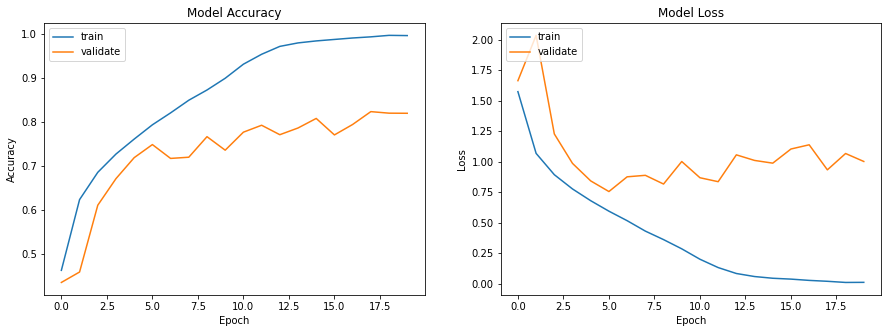

In [19]:
import matplotlib.pyplot as plt

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)

In [20]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test)

313/313 [==============================] - 45s 144ms/step - loss: 1.1225 - accuracy: 0.8070
Test loss: 1.122501015663147
Test accuracy: 0.8069999814033508
